In [ ]:
import os
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import soundfile as sf
from cached_path import cached_path
from hydra.utils import get_class
from omegaconf import OmegaConf
from importlib.resources import files

sys.path.append("/mnt/workspace/zhangjunan/F5-TTS/src/")

from f5_tts.infer.utils_infer import (
    device,
    infer_process,
    load_model,
    load_vocoder,
)
import torch
import torch.nn as nn
import torch.nn.functional as F

from random import random
from typing import Callable
import tqdm

import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint

from f5_tts.model.modules import MelSpec
from f5_tts.model.utils import (
    default,
    exists,
    get_epss_timesteps,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

import librosa
from matplotlib import pyplot as plt
from IPython.display import Audio, display

%matplotlib inline

sample_rate = 24000

target_sample_rate = 24000
n_mel_channels = 100
hop_length = 256
win_length = 1024
n_fft = 1024
target_rms = 0.1

In [ ]:
model_name = "F5TTS_v1_Base"
vocoder_name = "vocos"

vocoder = load_vocoder(vocoder_name=vocoder_name, device=device)
model_config_path = str(files("f5_tts").joinpath(f"configs/{model_name}.yaml"))
model_cfg = OmegaConf.load(model_config_path)

repo_name, ckpt_step, ckpt_type = "F5-TTS", 1250000, "safetensors"
checkpoint_path = str(cached_path(f"hf://SWivid/{repo_name}/{model_name}/model_{ckpt_step}.{ckpt_type}"))

model_cls = get_class(f"f5_tts.model.{model_cfg.model.backbone}")
model_arc = model_cfg.model.arch

ema_model = load_model(
    model_cls, 
    model_arc, 
    checkpoint_path, 
    mel_spec_type=vocoder_name, 
    device=device
)


In [62]:
class DenoisingOperator(nn.Module):
    """一个简单的算子，用于处理加性噪声的去噪问题。"""
    def __init__(self, sigma_n_sq):
        super().__init__()
        # sigma_n_sq 是噪声的方差，可以是一个标量或与数据同形状的张量
        self.sigma_n_sq = sigma_n_sq

    def gradient(self, x, measurement, return_loss=False):
        """计算似然梯度的核心部分。"""
        # 对于 y = x + n, n ~ N(0, sigma_n_sq)，
        # log p(y|x) = - (y-x)^2 / (2 * sigma_n_sq)
        # 梯度 ∇_x log p(y|x) 就是 (y-x) / sigma_n_sq
        grad = (measurement - x) / self.sigma_n_sq
        
        if return_loss:
            loss = F.mse_loss(x, measurement)
            return grad, loss
        return grad
        
    def loss(self, x, measurement):
        return F.mse_loss(x, measurement)

In [81]:
from mcmc import MCMCSampler

@torch.no_grad()
@torch.autocast(device_type="cuda", dtype=torch.float16)
def sample_denoise_daps(
    self,
    noisy_audio_path,
    vocoder,
    *,
    text=[" "],  # Null condition
    annealing_steps=50,
    denoising_steps=10,
    mcmc_steps=10,
    mcmc_lr=1e-5,
    cfg_strength=1.0,
    intermediate_steps_stride=10,
):
    self.eval()

    # --- 数据准备 (这部分不变) ---
    audio, sr = torchaudio.load(noisy_audio_path)
    if audio.shape[0] > 1: audio = torch.mean(audio, dim=0, keepdim=True)
    if sr != 24000: audio = torchaudio.transforms.Resample(sr, 24000)(audio)
    
    y_noisy_mel = self.mel_spec(audio.to(self.device)).permute(0, 2, 1)  # (B, n_mel, T)
    y_noisy_mel = y_noisy_mel.to(next(self.parameters()).dtype)
    print("Noisy Mel shape:", y_noisy_mel.shape)
    
    batch, max_duration, device = *y_noisy_mel.shape[:2], y_noisy_mel.device
    
    # --- DAPS 初始化 ---

    cond = torch.zeros(batch, 0, y_noisy_mel.shape[-1], device=device, dtype=y_noisy_mel.dtype)
    cond = cond.to(next(self.parameters()).dtype)
    cond_seq_len = cond.shape[1]

    # if lens is None:
    lens = torch.full((batch,), cond_seq_len, device=device, dtype=torch.long)

    # text = torch.zeros((batch, 1), device=device, dtype=torch.long)
    if isinstance(text, list):
        if exists(self.vocab_char_map):
            text = list_str_to_idx(text, self.vocab_char_map).to(device)
        else:
            text = list_str_to_tensor(text).to(device)
        assert text.shape[0] == batch
    
    cond_mask = lens_to_mask(lens)
    cond = F.pad(cond, (0, 0, 0, max_duration - cond_seq_len), value=0.0)
    cond_mask = F.pad(cond_mask, (0, max_duration - cond_mask.shape[-1]), value=False).unsqueeze(-1)
    step_cond = torch.where(cond_mask, cond, torch.zeros_like(cond))

    # 1. 退火调度器 (Annealing Scheduler) - *** 修改部分 ***
    # 标准的 Flow Matching/Diffusion 时间 t 从 0 (数据) 到 1 (噪声)。
    # 退火过程是从 t=1 开始，逐步降到 t=0。
    # 我们使用 linspace 来创建时间步长。
    annealing_times = torch.linspace(0.0, 1.0, annealing_steps + 1, device=device)
    noise_schedule = 1 - annealing_times  # 简单的线性噪声调度

    # 2. MCMC 采样器 (这部分不变)
    mcmc_sampler = MCMCSampler(
        num_steps=mcmc_steps,
        lr=mcmc_lr,
        tau=1,
        prior_solver='gaussian',
        mc_algo='langevin',
    )
    
    # 高斯近似和 Operator (这部分不变)
    operator = DenoisingOperator(sigma_n_sq=0.7)

    # 3. 准备文本条件 (这部分不变)
    if isinstance(text, list):
        if exists(self.vocab_char_map):
            text = list_str_to_idx(text, self.vocab_char_map).to(device)
        else:
            text = list_str_to_tensor(text).to(device)

    # --- DAPS 主循环 ---
    # 生成初始噪声 x_T (对应 t=1)
    xt = torch.randn_like(y_noisy_mel)
    
    intermediate_audios = {}
    
    pbar = tqdm.trange(annealing_steps)

    stop_at = 10 * (annealing_steps + 1)

    for step in pbar:
        t_current = annealing_times[step]
        t_next = annealing_times[step + 1]

        # === DAPS 步骤 1: 反向扩散 (完全去噪得到 x0hat) === - *** 修改部分 ***
        # 定义ODE函数，现在可以直接使用 t
        def fn(t, x):
            # print(x.shape, cond.shape, t)
            pred_cfg = self.transformer(
                x=x,
                cond=step_cond,
                text=text,
                time=t,
                cfg_infer=True,
                cache=True,
            )
            pred, null_pred = torch.chunk(pred_cfg, 2, dim=0)
            return pred + (pred - null_pred) * cfg_strength
    
        
        # ODE求解的时间点，从当前时间 t_current 求解到接近 0 的小值
        t_ode = torch.linspace(t_current, 1, denoising_steps, device=device)
        
        # 修改odeint的调用方式以适应Flow Matching的常规用法
        # 假设 odeint 可以直接处理从 t_current 开始的积分
        # 这里需要注意，torchdiffeq 的 odeint 输入是 (func, y0, t)
        # y0 是在 t[0] 时的值。我们的 t_ode[0] 就是 t_current。
        x0hat = odeint(fn, xt, t_ode, **self.odeint_kwargs)[-1]
        self.transformer.clear_cache()
        
        x0y = x0hat
        # ====================================================================
        # === DAPS 步骤 2: MCMC 修正得到 x0y (Langevin Dynamics展开) ===
        # ====================================================================

        # MCMC的初始点是ODE的解
        x_mcmc = x0hat.clone().detach()

        # 计算当前时间步对应的噪声标准差 sigma
        # 对于 x_t = t*x_data + (1-t)*noise，噪声标准差是 (1-t)
        # 注意：这里我们用的是生成 xt 的 t_current
        sigma_mcmc = 1.0 - t_current 
        # 防止 sigma 为 0 导致除零错误
        if sigma_mcmc < 1e-4: sigma_mcmc = 1e-4

        # MCMC 内循环
        for j in range(mcmc_steps):
            # 1. 计算数据保真项梯度 ∇_x log p(y|x)
            # operator.gradient 返回 (y-x)/sigma_n_sq
            data_fitting_grad = operator.gradient(x_mcmc, y_noisy_mel)
            
            # 2. 计算先验项梯度 ∇_x log p(x|x_t)
            # 基于高斯近似 p(x|x_t) ≈ N(x; x0hat, sigma_mcmc^2)
            # 梯度是 -(x - x0hat) / sigma_mcmc^2
            prior_grad = (x0hat - x_mcmc) / (sigma_mcmc ** 2)

            # 3. 合并梯度 (总分数)
            # 原文的 score_fn: data_term + xt_term + prior_term
            # 在我们的Flow Matching + 高斯近似下，简化为：
            # data_fitting_grad (对应原文 -data_fitting_grad/tau**2) + prior_grad
            # 注意符号：Langevin是梯度上升，所以梯度方向是正的
            total_grad = data_fitting_grad + prior_grad

            # 4. 生成随机噪声
            epsilon = torch.randn_like(x_mcmc)

            # 5. Langevin Dynamics 更新步骤
            # x_new = x + lr * grad + sqrt(2*lr) * noise
            x_mcmc = x_mcmc + mcmc_lr * total_grad + np.sqrt(2 * mcmc_lr) * epsilon

            # 检查NaN (可选但推荐)
            if torch.isnan(x_mcmc).any():
                print(f"Warning: NaN detected in MCMC step {j}. Resetting.")
                x_mcmc = x0hat.clone().detach() # 如果出错，重置为初始值
                break

        # MCMC循环结束，得到修正后的 x0y
        x0y = x_mcmc.detach()
        

        # === DAPS 步骤 3: 重新加噪得到 x_{t-1} === - *** 修改部分 ***
        # 重新加噪也需要用 t -> (x, sigma) 的关系。
        # 假设是标准的VP SDE: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        # 你的Flow Matching可能直接是 x_t = (1-t)*x_0 + t*x_1
        # 如果是后者，加噪过程更简单：
        if step < annealing_steps - 1:
            # 这是一个基于线性插值(lerp)的Flow Matching的加噪方式
            xt = t_next * x0y + (1 - t_next) * torch.randn_like(x0y)
            # xt = x0y + noise_schedule[step + 1] * torch.randn_like(x0y)
        else:
            xt = x0y # 最后一步，得到最终结果
        
        if step >= stop_at:
            print(f"Stopping early at step {step}")
            t_ode = torch.linspace(t_current, 1, denoising_steps, device=device)
            xt = odeint(fn, xt, t_ode, **self.odeint_kwargs)[-1]
            self.transformer.clear_cache()
            mel_for_vocoder = xt.permute(0, 2, 1)
            wave = vocoder.decode(mel_for_vocoder.to(torch.float32))
            wave_numpy = wave.squeeze().cpu().numpy()
            intermediate_audios[step] = wave_numpy
            # pbar.set_description(f"Annealing Step {step}/{annealing_steps}")
            break

        # --- 记录中间结果 (这部分不变) ---
        if step % intermediate_steps_stride == 0 or step == annealing_steps - 1:
            mel_for_vocoder = xt.permute(0, 2, 1)
            wave = vocoder.decode(mel_for_vocoder.to(torch.float32))
            wave_numpy = wave.squeeze().cpu().numpy()
            intermediate_audios[step] = wave_numpy
            # pbar.set_description(f"Annealing Step {step}/{annealing_steps}")

    return intermediate_audios

def inference_denoise_daps_entrypoint(
    noisy_audio_path,
    model_obj,
    vocoder,
    device,
    # --- DAPS 相关超参数 ---
    annealing_steps=50,
    denoising_steps=10,
    mcmc_steps=10,
    mcmc_lr=1e-5,
    cfg_strength=2.0,
    stride=10
):
    
    import types
    # 将新的采样函数绑定到模型实例上
    model_obj.sample_denoise_daps = types.MethodType(sample_denoise_daps, model_obj)
    
    intermediate_audios = model_obj.sample_denoise_daps(
        noisy_audio_path=noisy_audio_path,
        vocoder=vocoder,
        annealing_steps=annealing_steps,
        denoising_steps=denoising_steps,
        mcmc_steps=mcmc_steps,
        mcmc_lr=mcmc_lr,
        cfg_strength=cfg_strength,
        intermediate_steps_stride=stride,
    )
            
    return intermediate_audios

Noisy Mel shape: torch.Size([1, 586, 100])


  0%|          | 0/32 [00:00<?, ?it/s]

 97%|█████████▋| 31/32 [00:15<00:00,  2.00it/s]

100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

--- 音频 @ Timestep 0 ---


--- 音频 @ Timestep 10 ---


--- 音频 @ Timestep 20 ---


--- 音频 @ Timestep 30 ---


--- 音频 @ Timestep 31 ---


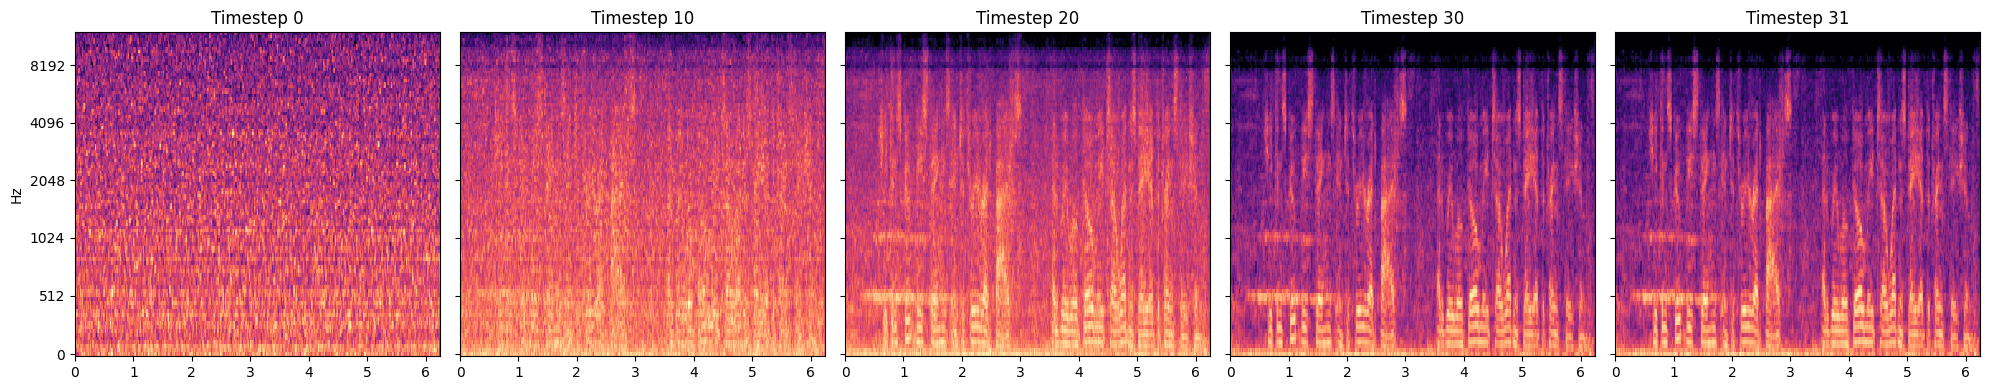

In [82]:

# --- 运行并展示结果 ---

intermediate_results = inference_denoise_daps_entrypoint(
    # noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/suvi_happy.wav",
    noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/p232_005.wav",
    model_obj=ema_model,
    vocoder=vocoder,
    device=device,
    annealing_steps=32,      # 外层退火循环次数
    denoising_steps=32,      # 内层去噪ODE步数
    mcmc_steps=100,           # MCMC修正步数
    mcmc_lr=1e-2,            # MCMC学习率，非常关键，需要微调
    cfg_strength=2.0,        # CFG强度
    stride=10                # 每隔多少步保存一次中间结果
)

# 循环展示每个中间步骤的音频
for step, audio_data in sorted(intermediate_results.items()):
    print(f"--- 音频 @ Timestep {step} ---")
    audio_player = Audio(data=audio_data, rate=target_sample_rate)
    display(audio_player)
# audio_player = Audio(data=intermediate_results[list(intermediate_results.keys())[-1]], rate=24000)
# display(audio_player)

torchaudio.save("denoise_out.wav", torch.from_numpy(intermediate_results[list(intermediate_results.keys())[-1]]).unsqueeze(0), 24000)

import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

sorted_items = sorted(intermediate_results.items())
num_plots = len(sorted_items)

fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4), sharey=True)
if num_plots == 1:
    axes = [axes]

for i, (step, audio_data) in enumerate(sorted_items):
    mel = librosa.feature.melspectrogram(    
        y=audio_data, 
        sr=24000, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length, 
        n_mels=n_mel_channels
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    img = librosa.display.specshow(
        mel_db,
        sr=target_sample_rate,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        ax=axes[i]
    )
    axes[i].set_title(f'Timestep {step}')
    if i > 0:
        axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)

plt.tight_layout()
plt.show()